# Table of Contents
* [1. Objectives and goals](#1.-Objectives-and-goals)
	* [1.1 Problem statement](#1.1-Problem-statement)
* [2. Training classifiers](#2.-Training-classifiers)
	* [2.1 Dataset](#2.1-Dataset)
	* [2.2 Attributes and features extraction](#2.2-Attributes-and-features-extraction)
	* [2.3 Models and optimization options](#2.3-Models-and-optimization-options)
* [3. Trained model evaluation](#3.-Trained-model-evaluation)
* [4. Using modes of locomotion classifier (i.e. trained model)](#4.-Using-modes-of-locomotion-classifier-%28i.e.-trained-model%29)
	* [4.1 Reviving trained model](#4.1-Reviving-trained-model)
	* [4.2 Decoding method](#4.2-Decoding-method)
* [5. Literature and references](#5.-Literature-and-references)


In [14]:
# first we define relevant directories
import sys
# in case PySeqLab package is not installed, 
# we can download the package repository from https://bitbucket.org/A_2/pyseqlab
# and then we add the location of the repository to the python system path
# location of the PySeqLab repository on disk -- INSERT location or discard if PySeqLab package is already installed
pyseqlab_package_dir = ""
sys.path.insert(0, pyseqlab_package_dir)
import os
# project directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
# src directory of this project
src_dir = os.path.join(project_dir, 'src')
sys.path.insert(0, src_dir)
# get the tutorials dir
tutorials_dir = os.path.join(project_dir, 'tutorials')
# to use for customizing the display/format of the cells
from IPython.core.display import HTML
with open(os.path.join(tutorials_dir, 'pseqlab_base.css')) as f:
    css = "".join(f.readlines())
HTML(css)

# 1. Objectives and goals

In this tutorial, we will learn about:
<ul>
<li> the process/workflow for building classifiers to identify (1) <strong>modes of locomotion</strong> and (2) <strong>gestures movements</strong> (i.e. based on CRFs model formalism)</li>
<li> training the built models and evaluating their performance</li>
<li> reviving the trained models and decoding new sequences (i.e. test sequences that were not used for training)</li>
</ul>

## 1.1 Problem statement

The Opportunity challenge  (Chavarriaga et al. 2013) is based on a subset of the <a href="https://archive.ics.uci.edu/ml/datasets/opportunity+activity+recognition"> Opportunity activity recognition dataset</a> comprising of recordings of activity of daily living (ADL) of 12 participants collected in a sensor rich environment (Chavarriaga et al. 2013; Roggen et al. 2010). The challenge is based on recordings of 4 participants who performed 6 different sessions/runs: five daily living sessions, following a loosely defined scenario/situations (see List 1 (Chavarriaga et al. 2013)) and one drill run session in which the participants performed 20 repetitions of predefined sequences (List 2 (Chavarriaga et al. 2013)).  

<blockquote>Given the sensor recordings, the objective of the challenge is to build models that can recognize and classify the modes of locomotion (Task A) and gestures movements (Task B). Task A consists of predicting 5 labels/classes and a Null state. Task B consists of predicting 18 labels/classes and a Null state.</blockquote>


List 1. Activity of daily living sequence (Chavarriaga et al. 2013)

ADL run consists of the following activity sequence:
<ol>
<li>Start: lying on the deckchair, get up</li>
<li>Groom: move in the room, check that all the objects are in the right places in the drawers and on shelves</li>
<li>Relax: go outside and have a walk around the building</li>
<li>Prepare coffee: prepare a coffee with milk and sugar using the coffee machine</li>
<li>Drink coffee: take coffee sips, act naturally in the environment</li>
<li>Prepare sandwich: include bread, cheese and salami, using the bread cutter and various knives and plates</li>
<li>Eat sandwich</li>
<li>Cleanup: put objects used to the original place or dish washer, cleanup the table</li>
<li>Break: lie on the deckchair</li>
</ol>

List 2. Drill session sequence (Chavarriaga et al. 2013)

Drill run consists of the following sequence:
<ol>
<li>Open and close the fridge</li>
<li>Open and close the dishwasher</li>
<li>Open and close 3 drawers (at different heights)</li>
<li>Open and close door 1</li>
<li>Open and close door 2</li>
<li>Turn on and off the lights</li>
<li>Clean table</li>
<li>Drink (standing)</li>
<li>Drink (sitting)</li>
</ol>

<strong><em>Reminder</em></strong>: To work with this tutorial interactively, we need to clone the <a href="https://bitbucket.org/A_2/har_activity_recognition">activity recognition repository from bitbucket</a> to our disk locally. Then, navigate to <strong>[cloned_package_dir]/tutorials</strong> where <strong>[cloned_package_dir]</strong> is the path to the cloned package folder. 

<strong><span style="color:red;">NB: </span></strong> <a href="https://bitbucket.org/A_2/pyseqlab">PySeqLab</a> should be already installed or included in the python system path before we proceed.

# 2. Training classifiers

The <code class="pseq_code">src</code> directory in the cloned repository includes three main modules: 
<ul>
<li><code class="pseq_code">train_activityrecognizer_workflow.py </code></li>
<li><code class="pseq_code">sensor_attribute_extractor.py </code></li>
<li><code class="pseq_code">processing_sensor_readings.py </code></li>
</ul>

As a prerequisite, refer to <a href="http://pyseqlab.readthedocs.io/en/latest/methods_tutorials.html">the tutorials</a> describing in detail the model building and training process using PySeqLab package.

## 2.1 Dataset

Originally, the dataset (<code class="pseq_code">OpportunityUCIDataset</code>) should be downloaded from the <a href="https://archive.ics.uci.edu/ml/datasets/opportunity+activity+recognition">UCI public repository</a> and placed under <code class="pseq_code">dataset</code> folder in the project's repository(see the printed tree path below):

<pre style="font-size:0.8em">
├── dataset
    │── OpportunityUCIDataset
    │   ├── README
    │   ├── dataset
    │   │   ├── S1-ADL1.dat
    │   │   ├── S1-ADL2.dat
    │   │   ├── S1-ADL3.dat
    │   │   ├── S1-ADL4.dat
    │   │   ├── S1-ADL5.dat
    │   │   ├── S1-Drill.dat
    │   │   ├── S2-ADL1.dat
    │   │   ├── S2-ADL2.dat
    │   │   ├── S2-ADL3.dat
    │   │   ├── S2-ADL4.dat
    │   │   ├── S2-ADL5.dat
    │   │   ├── S2-Drill.dat
    │   │   ├── S3-ADL1.dat
    │   │   ├── S3-ADL2.dat
    │   │   ├── S3-ADL3.dat
    │   │   ├── S3-ADL4.dat
    │   │   ├── S3-ADL5.dat
    │   │   ├── S3-Drill.dat
    │   │   ├── S4-ADL1.dat
    │   │   ├── S4-ADL2.dat
    │   │   ├── S4-ADL3.dat
    │   │   ├── S4-ADL4.dat
    │   │   ├── S4-ADL5.dat
    │   │   ├── S4-Drill.dat
    │   │   ├── column_names.txt
    │   │   ├── label_legend.txt
    │   ├── doc
    │   │   ├── ActivityRecognitionBaselines.pdf
    │   │   ├── Chavarriaga - The Opportunity challenge-A benchmark database for on-body sensor-based activity recognition (PRL, 2013).pdf
    │   │   ├── OPPORTUNITY_D5.1.pdf
    │   │   ├── Roggen - Collecting complex activity datasets in highly rich networked sensor environments (INSS, 2010).pdf
    │   │   ├── dataset_statistics.pdf
    │   │   ├── documentation.html
    │   │   ├── img
    │   │   │   ├── Fig1Cl.png
    │   │   │   ├── Fig1Cr.png
    │   │   │   ├── Reed_Switch_Configuration.png
    │   │   │   ├── arena3.png
    │   │   │   ├── bt_obj1.jpg
    │   │   │   ├── label.png
    │   │   │   ├── logos-opportunity-final_50p.png
    │   │   │   ├── logos-opportunity-final_50p_challenge.png
    │   │   │   ├── motion_jacket_complete.jpg
    │   │   │   ├── objects.JPG
    │   │   │   ├── reed.jpg
    │   │   │   ├── usb_sensor.jpg
    │   │   ├── locomotion_instances.tex
    │   │   ├── mlgesture_instances.tex
    │   ├── scripts
    │   │   ├── DataExplorer
    │   │   │   ├── label_panorama.fig
    │   │   │   ├── label_panorama.m
    │   │   │   ├── label_panorama_2009.fig
    │   │   │   ├── label_panorama_2009.m
    │   │   │   ├── readme.txt
    │   │   │   ├── root.txt
    │   │   │   ├── signal_scope_Callback.m
    │   │   │   ├── signal_scroll_Callback.m
    │   │   │   ├── underscore_clean.m
    │   │   ├── benchmark
    │   │   │   ├── RunBenchmarking.m
    │   │   │   ├── classifiers
    │   │   │   │   ├── GausianClassify.m
    │   │   │   │   ├── classifyAndReject.m
    │   │   │   │   ├── knn.m
    │   │   │   │   ├── nccClassify.m
    │   │   │   ├── data
    │   │   │   ├── features
    │   │   │   │   ├── expandingLabels.m
    │   │   │   │   ├── featureExtraction.m
    │   │   │   │   ├── featureReduction.m
    │   │   │   │   ├── missingValueHandler.m
    │   │   │   │   ├── movtimavg.m
    │   │   │   │   ├── windowingLabels.m
    │   │   │   ├── measures
    │   │   │   │   ├── AreaUnderROC.m
    │   │   │   │   ├── clsAccuracy.m
    │   │   │   │   ├── measures.m
    │   │   │   │   ├── rocCurves.m
    │   │   │   │   ├── separate.m
    │   │   │   │   ├── ward
    │   │   │   │   │   ├── README
    │   │   │   │   │   ├── a-categorisation-of-performance-errors-in-continuous-context-recognition-ward-2005.pdf
    │   │   │   │   │   ├── mset.m
    │   │   │   │   │   ├── mset_segments.m
    │   │   │   │   │   ├── plot_mset_errors.m
    │   │   │   │   │   ├── read_seg_info.m
    │   │   │   │   │   ├── test_mset_plotting.m
    │   │   │   │   │   ├── wardbars.m
    │   │   │   │   │   ├── write_seg_info.m
    │   │   │   │   ├── wardbars.m
    │   │   │   ├── parameters.m
    │   │   │   ├── prepareData.m
    │   │   │   ├── readme.txt
    │   │   │   ├── res2mat.m
    │   │   │   ├── tanalyze.m
    │   │   │   ├── tarrange.m
</pre>

Then we process the data files by running <code>run_data_generation_workflow()</code> function that is found under <code class="pseq_code">processing_sensor_readings.py</code> module. The result will be two new generated folders; one for the <code class="pseq_code">locomotion</code> task (i.e. task A) and the second for <code class="pseq_code">gestures</code> task (i.e. task B). Both folders will include the processed training and test files. 

The tree path will look like this:
<pre style="font-size:0.8em">
├── dataset
    ├── gestures
    │   ├── sensor_test_wsize15_stepsize8_yagglast_gestures.pkl
    │   ├── sensor_train_wsize15_stepsize8_yagglast_gestures.pkl
    │   ├── test.txt
    │   ├── test_discretized.txt
    │   ├── test_discretized_iob.txt
    │   ├── train.txt
    │   ├── train_discretized.txt
    │   ├── train_discretized_iob.txt
    ├── locomotion
    │   ├── sensor_test_wsize15_stepsize8_yagglast_locomotion.pkl
    │   ├── sensor_train_wsize15_stepsize8_yagglast_locomotion.pkl
    │   ├── test.txt
    │   ├── test_discretized.txt
    │   ├── test_discretized_iob.txt
    │   ├── train.txt
    │   ├── train_discretized.txt
    │   ├── train_discretized_iob.txt
</pre>

We will be using the training and test files (i.e. <code class="pseq_code">train_discretized_iob.txt and test_discretized_iob.txt</code>) in <code class="pseq_code">locomotion</code> folder and the <code class="pseq_code">gestures</code> folder to build our first classifier (task A) and the second classifier (task B) respectively.

Briefly, our data processing pipeline performs the following:
For each task, it aggregates all the original training files representing the sensor recordings by considering each training file to be representing one sequence. Given that we have 14 training files, we will end up with 14 training sequences.
Then we compress the sequences to generate segments using a sliding window of 500 ms (i.e. 15 measurements) and step size of 250 ms (8 measurements). The label of each generated segment was the label of the last measurement in the segment. Moreover, we computed the mean value of each sensor channel in the segment that was later discretized using <code>MDLPC method</code> (Fayyad et al. 1993) implemented in (Raymond, 2013). In the last step, we encode the labels of the generated segments using <a href="https://en.wikipedia.org/wiki/Inside_Outside_Beginning">BIO/IOB format</a>. In this format, each entity class will have two labels: <code class="pseq_code">B-class</code> (beginning of entity class) and <code class="pseq_code">I-class</code> (within/continuation of entity class). Hence, the total number of classes will be increased to 9 for task A and 33 for task B.

In [ ]:
from processing_sensor_readings import *
run_data_generation_workflow()

## 2.2 Attributes and features extraction

We start by defining our attribute extractor that will be used to generate attributes from the parsed sequences. Our attribute extractor <code class="pseq_class">SensorAttributeExtractorCateg</code> is subclass of <code class="pseq_class">GenericAttributeExtractor</code> class implemented in <code class="pseq_code">sensor_attribute_extractor.py</code> module. It defines attributes based on the discretized values of each sensor channel. Below is <a href="#sensor_attrext_demo">an example</a> of the attributes extracted using our <code class="pseq_class">SensorAttributeExtractorCateg</code> class from a sequence in our training file. 

After defining our attribute extractor, we define the feature templates that are used by the feature extractors to generate features. Feature templates and feature extraction are described in detail in <a href="http://pyseqlab.readthedocs.io/en/latest/_static/templates_and_features_extraction.html">this tutorial</a>.

In the <code class="pseq_code">train_activityrecognizer_workflow.py</code> module, we define our feature templates using <code class="pseq_function">template_config()</code> function.

<pre style="font-size:0.75em">
def template_config():
    template_generator = TemplateGenerator()
    templateXY = {}
    # generating template for tracks
    for track_attr_name in track_attr_names:
        template_generator.generate_template_XY(track_attr_name, 
                                                ('1-gram:2-gram', range(-3,4)),
                                                '1-state',
                                                templateXY)
        template_generator.generate_template_XY(track_attr_name, 
                                                ('1-gram', range(0,1)),
                                                '2-states:3-states',
                                                templateXY)
    templateY = {'Y':()}
    return(templateXY, templateY)
</pre>

The defined templates include all values of the 113 sensor channel (i.e.<code class="pseq_code"> s_0:112</code>). The notation <code class="pseq_code">s_0:112</code> represents the recordings of all 113 sensor channels. <br/>

For the sensor channels tracks (i.e. <code class="pseq_code">s_0:112</code>):

<ol>
<li>
<ul>
<li>We define a window of size 7 centered at each position in the sequence. We pass through the sequence from left to right, where at each position, we construct a window of size 7 (a window that includes attributes at three previous positions, current position,  and three forward/future positions)</li>
<li>We extract unigrams and bigrams (i.e. <code class="pseq_code">1-gram:2-grams</code>) in the specified window </li>
<li>We join these attributes with (1) the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>
<br/>
<li>
<ul>
<li>We define another window of size 1 centered at each position in the sequence.  We pass through the sequence from left to right, where at each position, we construct a window of size 1 (i.e. a window that includes the current attribute).</li>
<li>We join these attributes using (1) the previous and current state, and (2) the two previous states and the current state (i.e. <code class="pseq_code">Y labels</code>)</li>
</ul>
</ol>

<a id="sensor_attrext_demo"></a>

In [ ]:
from sensor_attribute_extractor import *
example()

## 2.3 Models and optimization options

In the <code class="pseq_code">train_activityrecognizer_workflow.py</code> module, we implement the training workflow. In this section, we describe the training setup and the chosen options for performing the training.

We used the following classes:
<ul><li>feature extractor (<code class="pseq_class">HOFeatureExtractor)</code>,</li>
<li>CRFs model (<code class="pseq_class">HOCRFAD</code>) and</li>
<li>CRFs model representation (<code class="pseq_class">HOCRFADModelRepresentation</code>)</li>
</ul>


For the training method (i.e. optimization options), we used the following options:
<ul><li>stochastic gradient ascent with adaptive learning rate (ADADELTA), (Zeiler, 2012) (<code class="pseq_code">method = SGA-ADADELTA</code>),</li>
<li>with <code class="pseq_code">l2</code> regularization <code class="pseq_code">(regularization_type = l2)</code> and regularization value equal to 1 <code class="pseq_code">(regularization_value = 1)</code>,</li>
<li>and 15 passes through the training data <code class="pseq_code">num_epochs = 15</code>)</li>
</ul>

To run the training process, we use <code class="pseq_function">run_training(args)</code> function. We pass the optimization options, the function generating the defined feature templates, the target label (i.e. <code class="pseq_code">locomotion or gestures</code>) and the train and test file names (<a href="#sensor_trainmodel">see this code snippet</a>). The training process for each task (i.e. task A and B) will perform the following:
<ol>
<li> read the training file (<code class="pseq_code">train_discretized_iob.txt</code>) and parse it into sequences</li>
<li> process and dump the parsed sequences on disk in a relevant format to be later used in the learning framework </li>
<li> build a model based on the processed training sequences </li>
<li> train the model weights (i.e. estimate the feature weights) using the specified optimization method</li>
<li> use the trained model to decode the training sequences and write the result to a file</li>
<li> read the test file (<code class="pseq_code">test_discretized_iob.txt</code>) parse it into sequences</li>
<li> use the trained model to decode the testing sequences and write the result to a file</li>
<li> return the path to the trained model directory </li>
</ol>

The return value of the training function (i.e. <code class="pseq_code">model_dir</code> -- <a href="#sensor_trainmodel">see code snippet below</a>) is the path to the trained model.

During model training, we track the estimated average loglikelihood by plotting the generated <code class="pseq_code">avg_loglikelihood_training</code> file. 

<a id="sensor_trainmodel"></a>

In [9]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
from train_activityrecognizer_workflow import *
# import the module containing training workflow
# we use only 1 sequence for demonstration
# to go through the whole file simply omit passing the num_seqs keyword argument
num_seqs = 1
optimization_options = {"method" : "SGA-ADADELTA",
                        "regularization_type": "l2",
                        "regularization_value":1,
                        "num_epochs":10,
                        "tolerance":1e-6
                        }

target_label = 'locomotion'
train_fname = 'train_discretized_iob.txt'
test_fname = 'test_discretized_iob.txt'
# demonstrate training modes of locomotion classifier using only 1 sequence from the both the training and test file
model_dir = run_training(optimization_options, 
                         template_config, 
                         target_label, 
                         train_fname, 
                         test_fname, 
                         num_seqs=num_seqs)

# demonstrate training gestures classifier using only 1 sequence from the both the training and test file
# uncomment the below lines
# target_label = 'gestures'
# model_dir = run_training(optimization_options, 
#                          template_config, 
#                          target_label, 
#                          train_fname, 
#                          test_fname, 
#                          num_seqs=num_seqs)

# using all sequences from the both the training and test file

# optimization_options = {"method" : "SGA-ADADELTA",
#                         "regularization_type": "l2",
#                         "regularization_value":1,
#                         "num_epochs":15,
#                         "tolerance":1e-6
#                         }

# model_dir = run_training(optimization_options, 
#                          template_config, 
#                          target_label, 
#                          train_fname, 
#                          test_fname)

1 sequences have been processed
dumping globalfeatures -- processed seqs:  1
constructing model -- processed seqs:  1
identifying model active features -- processed seqs:  1
k  0
num seqs left: 0
reldiff = 1.0
k  1
num seqs left: 0
reldiff = 0.6520631855916672
k  2
num seqs left: 0
reldiff = 0.7223171060020179
k  3
num seqs left: 0
reldiff = 0.373546837473899
k  4
num seqs left: 0
reldiff = 0.6267405994339736
k  5
num seqs left: 0
reldiff = 0.4434732095449679
k  6
num seqs left: 0
reldiff = 0.6527230689414977
k  7
num seqs left: 0
reldiff = 0.8719422301214974
k  8
num seqs left: 0
reldiff = 0.1331403102782974
k  9
num seqs left: 0
reldiff = 0.015300976648731663
sequence decoded -- 0 sequences are left
{}
identifying model active features -- processed seqs:  1
sequence decoded -- 0 sequences are left
{}


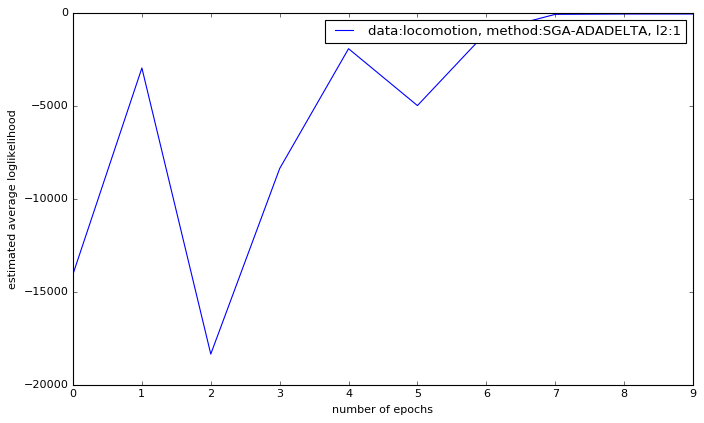

In [10]:
from pyseqlab.utilities import ReaderWriter
def plot_avg_loglikelihood(model_dir):
    # plot the estimated average loglikelihood during training phase
    avg_ll = ReaderWriter.read_data(os.path.join(model_dir, 'avg_loglikelihood_training'))
    plt.plot(avg_ll[1:], label="data:{}, method:{}, {}:{}".format(target_label,
                                                                  optimization_options['method'], 
                                                                  optimization_options['regularization_type'],
                                                                  optimization_options['regularization_value']))             
    plt.legend(loc='upper right')
    plt.xlabel('number of epochs')
    plt.ylabel('estimated average loglikelihood')
    
plot_avg_loglikelihood(model_dir)

# 3. Trained model evaluation

<strong><span style="color:red">NB</span></strong>: Before proceeding, we have to unzip the <code class="pseq_code">trained_models</code> directory so that we can explore and assess the trained models.

To evaluate the performance of the trained models, we will use the <code class="pseq_function">eval_models(args)</code> function in the <code class="pseq_code">train_activityrecognizer_workflow.py</code> module. It takes a list of the trained models' path on disk. An example of a trained model directory will have the following structure:

<pre style="font-size:0.8em;">
├── avg_loglikelihood_training
├── crf_training_log.txt
├── decoding_seqs
│   ├── test_fold_0.txt
│   ├── train_fold_0.txt
├── model_parts
│   ├── class_desc.txt
│   ├── FE_templateX
│   ├── FE_templateY
│   ├── MR_L
│   ├── MR_modelfeatures
│   ├── MR_modelfeaturescodebook
│   ├── MR_Ycodebook
│   ├── weights
</pre>

Each model has a <code class="pseq_code">model_parts</code> folder. The decoded sequences are found under <code class="pseq_code">decoding_seqs</code> folder where we have the decoding of the training and test files. We evaluate the performance of the trained models by evaluating the weighted F1-measure using those files as in the <a href="#sensor_evalmodel">code snippet below</a>. 

<a id="sensor_evalmodel"></a>

In [11]:
# to evaluate the models' performance on the sequence level, using already trained models
# eval_models takes a list of trained models path on disk
trainedmodels_rootdir = os.path.join(project_dir, 'trained_models')
models_folders = ("2017_3_31-17_1_8_31139",  "2017_4_4-18_13_42_852521")
models_dir = [os.path.join(trainedmodels_rootdir, folder) for folder in models_folders]
eval_models(models_dir)

train_fold_0.txt
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     11538
          1       1.00      1.00      1.00     28970
          2       1.00      1.00      1.00     16295
          3       1.00      1.00      1.00     11120
          4       1.00      1.00      1.00      1818

avg / total       1.00      1.00      1.00     69741

weighted f1:
1.0
micro f1:
1.0
test_fold_0.txt
             precision    recall  f1-score   support

          0       0.85      0.89      0.87      3060
          1       0.86      0.91      0.88      4655
          2       0.87      0.78      0.82      3404
          3       0.99      0.98      0.99      3029
          4       0.98      0.95      0.96       695

avg / total       0.89      0.89      0.89     14843

weighted f1:
0.89097738527
micro f1:
0.891396617934
train_fold_0.txt
             precision    recall  f1-score   support

          0       1.00      0.99      0.99     48521
          1 

# 4. Using modes of locomotion classifier (i.e. trained model)

In this section, we demonstrate how to revive a previously trained model for identifying modes of locomotion using <a href="https://archive.ics.uci.edu/ml/datasets/opportunity+activity+recognition"> Opportunity activity recognition dataset</a>.

<br/>
As a reminder, the trained model (including its components) are found under <code class="pseq_code">trained_models </code>folder that has the following structure:
<pre style="font-size:0.8em;">
── 2017_3_31-17_1_8_31139
│   ├── crf_training_log.txt
│   ├── model_parts
│   │   ├── class_desc.txt
│   │   ├── MR_L
│   │   ├── MR_modelfeatures
│   │   ├── MR_modelfeaturescodebook_oldrepr
│   │   ├── MR_Ycodebook
│   │   ├── FE_templateY
│   │   ├── FE_templateX
│   │   ├── weights
│   │   ├── MR_modelfeaturescodebook
│   ├── decoding_seqs
│   │   ├── test_fold_0.txt
│   │   ├── train_fold_0.txt
</pre>

## 4.1 Reviving trained model

To use/revive our trained model we use <code class="pseq_function">revive_learnedmodel(args)</code> function that takes:
<ul><li>the path/directory to the trained model</li>
<li>the attribute extractor class (i.e. <code class="pseq_class">SensorAttributeExtractorCateg</code> class)</li>
</ul>

The folder <code class="pseq_code">2017_3_31-17_1_8_31139</code> under <code class="pseq_code">trained_models</code> folder represents the path to our trained model.

In [4]:
# we get the trained model parts directory -- check the tree path in the cell above
trained_model_dir = os.path.join(project_dir, 'trained_models')
# loading the trained model
crf_m = revive_learnedmodel(os.path.join(trained_model_dir, '2017_3_31-17_1_8_31139'), SensorAttributeExtractorCateg)

After we have revived our model, we need sequences to decode. We will use the test dataset we already procecessed under the dataset directory. Just as a reminder, the tree path is:
<pre style="font-size:0.8em">
├── dataset
    ├── locomotion
    │   ├── sensor_test_wsize15_stepsize8_yagglast_locomotion.pkl
    │   ├── sensor_train_wsize15_stepsize8_yagglast_locomotion.pkl
    │   ├── test.txt
    │   ├── test_discretized.txt
    │   ├── test_discretized_iob.txt
    │   ├── train.txt
    │   ├── train_discretized.txt
    │   ├── train_discretized_iob.txt
</pre>

To read the test file, we will use <code class="pseq_class">DataFileParser</code> class in the <code class="pseq_code">utilities</code> module. 

In [ ]:
from pyseqlab.utilities import DataFileParser
# initialize a data file parser
dparser = DataFileParser()
    
# initialize a data file parser
dparser = DataFileParser()
# provide the options to parser such as the header info, the separator between words and if the y label is already existing
# main means the header is found in the first line of the file
header = ["s_{}".format(i) for i in range(113)] + ['locomotion']
# y_ref is a boolean indicating if the label to predict is already found in the file
y_ref = True
# spearator between the observations
column_sep = " "
seqs = []
# read all sequences
for seq in dparser.read_file(os.path.join(dataset_dir, 'locomotion', 'test_discretized_iob.txt'), header, y_ref=y_ref, column_sep = column_sep):
    seqs.append(seq)
        
# printing one sequence for display
# print(seqs[0])
print("number of parsed sequences is: ", len(seqs))

## 4.2 Decoding method

Then, we decide the decoding options for our model to use. The main method for decoding is <code class="pseq_method">decode_seqs(decoding_method, out_dir, **kwargs)</code> that takes two arguments and multiple keyword arguments. 
<br/>

The obligatory arguments are:
<ol>
<li>
<code class="pseq_args">decoding_method</code>: string representing the decoding method such as <code class="pseq_code">'viterbi'</code>
</li>
<li>
<code class="pseq_args">output_dir</code>: string, the output directory representing the path where the parsing would take place
</li>
</ol>

For the keyword arguments, the main ones to specify are:
<ul>
<li>
<code class="pseq_args">seqs</code>: the list of sequences we already parsed/read from the text file we need to label
</li>
<li>
<code class="pseq_args">file_name</code>: the name of the file where decoded sequences will be written to (it is optional)
</li>
<li>
<code class="pseq_args">sep</code>: the separator between the columns/observations when writing decoded sequences to the specified file using <code class="pseq_args">file_name</code> keyword argument
</li>
</ul>

In [6]:
decoding_method = 'viterbi'
output_dir = os.path.join(project_dir, 'tutorials')
sep = "\t"
# decode sequences
seqs_decoded = crf_m.decode_seqs(decoding_method, output_dir, seqs= seqs, file_name = 'tutorial_seqs_decoding.txt', sep=sep)

identifying model active features -- processed seqs:  1
identifying model active features -- processed seqs:  2
identifying model active features -- processed seqs:  3
identifying model active features -- processed seqs:  4
sequence decoded -- 3 sequences are left
sequence decoded -- 2 sequences are left
sequence decoded -- 1 sequences are left
sequence decoded -- 0 sequences are left


The decoded sequences will be found under the <code class="pseq_code">tutorials</code> directory (i.e. current directory) under <code class="pseq_code">decoding_seqs</code> folder.
<pre style="font-size:0.8em;">
|---tutorials
|      |---decoding_seqs
|      |             |---tutorial_seqs_decoding.txt
</pre>
The <code class="pseq_code">tutorial_seqs_decoding.txt</code> file will follow the same template/format of the <code class="pseq_code">test_discretized_iob.txt</code> file we already parsed earlier, but this time with additional column that contains our model's predictions.
We can check our model performance by using  the <code class="pseq_code">eval_decoded_file(args)</code> function in the <code class="pseq_code">train_activityrecognizer_workflow.py</code> module.

In [7]:
# evaluate model on test data set
new_decseqs_file = os.path.join(tutorials_dir, 'decoding_seqs','tutorial_seqs_decoding.txt')
eval_decoded_file(new_decseqs_file, other_symbol='0')

             precision    recall  f1-score   support

          0       0.85      0.89      0.87      3060
          1       0.86      0.91      0.88      4655
          2       0.87      0.78      0.82      3404
          3       0.99      0.98      0.99      3029
          4       0.98      0.95      0.96       695

avg / total       0.89      0.89      0.89     14843

weighted f1:
0.89097738527
micro f1:
0.891396617934


Our model achieves overall weighted F1-measure equal to 89%<br/>

Although, the trained models clearly overfit the training data (i.e. the F1-scores are beyond the 97%), we obtained a very good performance using the test data. Clearly, the effort should be on experimenting with various feature templates and regularization values, various model structures (i.e. smaller models) even different representation of the training and testing sequences (i.e. fixed length sequences). We leave this as an exercise for the readers ... :)


# 5. Literature and references

Daniel Roggen, Alberto Calatroni, Mirco Rossi, Thomas Holleczek, Gerhard Tröster, Paul Lukowicz, Gerald Pirkl, David Bannach, Alois Ferscha, Jakob Doppler, Clemens Holzmann, Marc Kurz, Gerald Holl, Ricardo Chavarriaga, Hesam Sagha, Hamidreza Bayati, and José del R. Millàn. "Collecting complex activity data sets in highly rich networked sensor environments" In Seventh International Conference on Networked Sensing Systems (INSS’10), Kassel, Germany, 2010. 

Ricardo Chavarriaga, Hesam Sagha, Alberto Calatroni, Sundaratejaswi Digumarti, Gerhard Tröster, José del R. Millán, Daniel Roggen. "The Opportunity challenge: A benchmark database for on-body sensor-based activity recognition", Pattern Recognition Letters, 2013

Raymond, C. (2013). Robust tree-structured Named Entities Recognition from speech. In 2013 IEEE International Conference on Acoustics, Speech and Signal Processing (pp. 8475–8479). IEEE. http://doi.org/10.1109/ICASSP.2013.6639319
 
Fayyad, U. M., & Irani, K. B. (1993). Multi-Interval Discretization of Continuous-Valued Attributes for Classification Learning. In Proceedings of the International Joint Conference on Uncertainty in AI (pp. 1022–1027). Retrieved from http://trs-new.jpl.nasa.gov/dspace/handle/2014/35171
